In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

import sbgm
import data
import configs

In [2]:
datasets_path = "."
root_dir = "."

config = configs.moons_config()

key = jr.key(config.seed)
data_key, model_key, train_key = jr.split(key, 3)

dataset = data.moons(data_key)

sharding = sbgm.shard.get_sharding()
    
# Diffusion model 
model = sbgm.models.get_model(
    model_key, 
    config,
    model_type=config.model.model_type, 
    data_shape=dataset.data_shape, 
)

# Stochastic differential equation (SDE)
sde = sbgm.sde.get_sde(config.sde)

Running on 1 local devices: 
	[CpuDevice(id=0)]
Sharding:
 None


In [3]:
# Fit model to dataset
model = sbgm.train.train(
    train_key,
    model,
    sde,
    dataset,
    config,
    reload_opt_state=False,
    sharding=sharding,
    save_dir=root_dir
)

Training SGM with VP SDE on moons dataset.


100%|██████████| 100000/100000 [12:36<00:00, 132.14it/s, Lt=2.096E-01, Lv=2.040E-01]


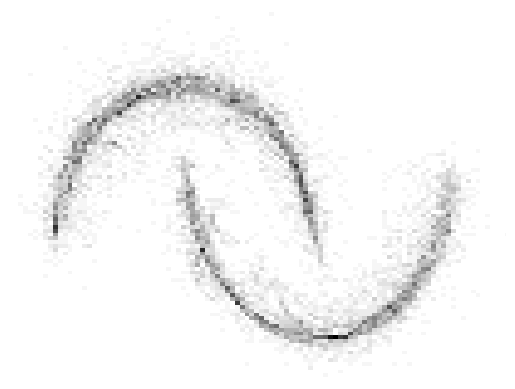

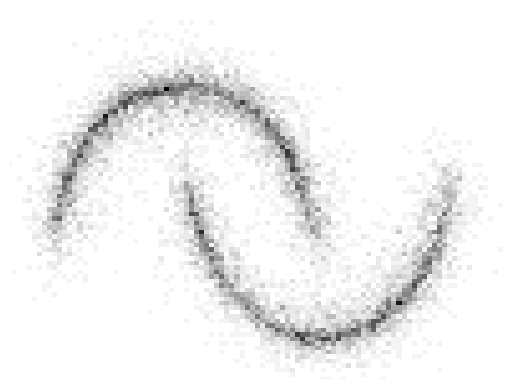

In [8]:
from sbgm._sample import get_eu_sample_fn, get_ode_sample_fn

n_sample = 10_000

key_A, key_sample = jr.split(key)
key_samples = jr.split(key, n_sample)

ode_sample_fn = get_ode_sample_fn(model, sde, dataset.data_shape)
samples = jax.vmap(ode_sample_fn, in_axes=(0, None, None))(key_samples, None, None)

plt.figure()
plt.hist2d(*samples.T, bins=100, cmap="gray_r")
plt.ylim(-1.6, 1.5)
plt.xlim(-2.5, 3.)
plt.axis("off")
plt.show()

eu_sample_fn = get_eu_sample_fn(model, sde, dataset.data_shape)
samples = jax.vmap(eu_sample_fn, in_axes=(0, None, None))(key_samples, None, None)

plt.figure()
plt.hist2d(*samples.T, bins=100, cmap="gray_r")
plt.ylim(-1.6, 1.5)
plt.xlim(-2.5, 3.)
plt.axis("off")
plt.show()

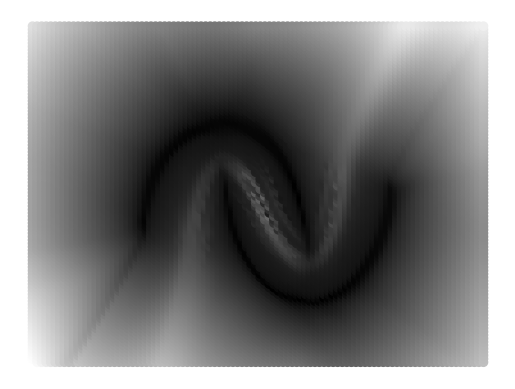

In [5]:
from sbgm._ode import get_log_likelihood_fn

x, y = jnp.mgrid[-4.:4.:100j, -2.:2.:100j]
X = jnp.stack([x.ravel(), y.ravel()], axis=1)

log_likelihood_fn = get_log_likelihood_fn(
    model, sde, dataset.data_shape, exact_logp=True
)
L_X = jax.vmap(log_likelihood_fn, in_axes=(0, None, None, None))(X, None, None, None)

plt.figure()
plt.scatter(*X.T, c=L_X, cmap="gray_r")
plt.axis("off")
plt.show()